## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

reduce_lr_factor = [0.3, 0.5, 0.7]
reduce_lr_patient = [5, 8, 10]

In [9]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, reduce_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

50000/50000 [==============================] - 5s 107us/step - loss: 0.8110 - accuracy: 0.7393 - val_loss: 1.4655 - val_accuracy: 0.5023
Epoch 45/50
50000/50000 [==============================] - 5s 107us/step - loss: 0.8102 - accuracy: 0.7404 - val_loss: 1.4658 - val_accuracy: 0.5017
Epoch 46/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.8099 - accuracy: 0.7406 - val_loss: 1.4658 - val_accuracy: 0.5012
Epoch 47/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.8101 - accuracy: 0.7411 - val_loss: 1.4658 - val_accuracy: 0.5011
Epoch 48/50
50000/50000 [==============================] - 5s 94us/step - loss: 0.8097 - accuracy: 0.7398 - val_loss: 1.4660 - val_accuracy: 0.5013

Epoch 00048: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.
Epoch 49/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.8090 - accuracy: 0.7405 - val_loss: 1.4662 - val_accuracy: 0.5019
Epoch 50/50
50000/50000 [================

50000/50000 [==============================] - 5s 100us/step - loss: 2.6600 - accuracy: 0.1655 - val_loss: 2.6635 - val_accuracy: 0.1709
Epoch 37/50
50000/50000 [==============================] - 5s 95us/step - loss: 2.6593 - accuracy: 0.1648 - val_loss: 2.6635 - val_accuracy: 0.1711
Epoch 38/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.6594 - accuracy: 0.1657 - val_loss: 2.6632 - val_accuracy: 0.1708
Epoch 39/50
50000/50000 [==============================] - 5s 98us/step - loss: 2.6589 - accuracy: 0.1653 - val_loss: 2.6631 - val_accuracy: 0.1710
Epoch 40/50
50000/50000 [==============================] - 5s 97us/step - loss: 2.6598 - accuracy: 0.1650 - val_loss: 2.6629 - val_accuracy: 0.1710
Epoch 41/50
50000/50000 [==============================] - 6s 114us/step - loss: 2.6591 - accuracy: 0.1642 - val_loss: 2.6626 - val_accuracy: 0.1708

Epoch 00041: ReduceLROnPlateau reducing learning rate to 5.904900035602622e-09.
Epoch 42/50
50000/50000 [===============

Epoch 29/50
50000/50000 [==============================] - 5s 110us/step - loss: 2.9649 - accuracy: 0.0985 - val_loss: 2.9617 - val_accuracy: 0.0917
Epoch 30/50
50000/50000 [==============================] - 5s 108us/step - loss: 2.9656 - accuracy: 0.0974 - val_loss: 2.9622 - val_accuracy: 0.0917
Epoch 31/50
50000/50000 [==============================] - 6s 113us/step - loss: 2.9654 - accuracy: 0.0982 - val_loss: 2.9621 - val_accuracy: 0.0916

Epoch 00031: ReduceLROnPlateau reducing learning rate to 4.7829690208445185e-11.
Epoch 32/50
50000/50000 [==============================] - 6s 119us/step - loss: 2.9654 - accuracy: 0.0976 - val_loss: 2.9622 - val_accuracy: 0.0916
Epoch 33/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.9651 - accuracy: 0.0976 - val_loss: 2.9622 - val_accuracy: 0.0917
Epoch 34/50
50000/50000 [==============================] - 5s 97us/step - loss: 2.9660 - accuracy: 0.0974 - val_loss: 2.9624 - val_accuracy: 0.0917
Epoch 35/50
50000/50000 [

50000/50000 [==============================] - 5s 101us/step - loss: 3.0026 - accuracy: 0.1066 - val_loss: 2.9888 - val_accuracy: 0.1117

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1e-12.
Epoch 22/50
50000/50000 [==============================] - 5s 102us/step - loss: 3.0033 - accuracy: 0.1064 - val_loss: 2.9895 - val_accuracy: 0.1117
Epoch 23/50
50000/50000 [==============================] - 5s 97us/step - loss: 3.0027 - accuracy: 0.1058 - val_loss: 2.9900 - val_accuracy: 0.1117
Epoch 24/50
50000/50000 [==============================] - 5s 99us/step - loss: 3.0026 - accuracy: 0.1056 - val_loss: 2.9903 - val_accuracy: 0.1116
Epoch 25/50
50000/50000 [==============================] - 5s 98us/step - loss: 3.0031 - accuracy: 0.1063 - val_loss: 2.9904 - val_accuracy: 0.1117
Epoch 26/50
50000/50000 [==============================] - 5s 107us/step - loss: 3.0028 - accuracy: 0.1063 - val_loss: 2.9903 - val_accuracy: 0.1116
Epoch 27/50
50000/50000 [==============================]

50000/50000 [==============================] - 5s 100us/step - loss: 2.9185 - accuracy: 0.1111 - val_loss: 2.8996 - val_accuracy: 0.1103
Epoch 16/50
50000/50000 [==============================] - 6s 110us/step - loss: 2.9174 - accuracy: 0.1111 - val_loss: 2.9093 - val_accuracy: 0.1104
Epoch 17/50
50000/50000 [==============================] - 6s 119us/step - loss: 2.9176 - accuracy: 0.1123 - val_loss: 2.9159 - val_accuracy: 0.1105
Epoch 18/50
50000/50000 [==============================] - 6s 126us/step - loss: 2.9177 - accuracy: 0.1123 - val_loss: 2.9201 - val_accuracy: 0.1107
Epoch 19/50
50000/50000 [==============================] - 6s 116us/step - loss: 2.9189 - accuracy: 0.1110 - val_loss: 2.9231 - val_accuracy: 0.1111
Epoch 20/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.9177 - accuracy: 0.1122 - val_loss: 2.9247 - val_accuracy: 0.1115
Epoch 21/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.9181 - accuracy: 0.1109 - val_loss:

Epoch 10/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.9872 - accuracy: 0.1138 - val_loss: 2.7935 - val_accuracy: 0.1184
Epoch 11/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.9855 - accuracy: 0.1145 - val_loss: 2.8329 - val_accuracy: 0.1182
Epoch 12/50
50000/50000 [==============================] - 5s 106us/step - loss: 2.9857 - accuracy: 0.1131 - val_loss: 2.8660 - val_accuracy: 0.1169
Epoch 13/50
50000/50000 [==============================] - 6s 117us/step - loss: 2.9878 - accuracy: 0.1131 - val_loss: 2.8928 - val_accuracy: 0.1169
Epoch 14/50
50000/50000 [==============================] - 5s 104us/step - loss: 2.9876 - accuracy: 0.1139 - val_loss: 2.9135 - val_accuracy: 0.1170
Epoch 15/50
50000/50000 [==============================] - 5s 104us/step - loss: 2.9853 - accuracy: 0.1134 - val_loss: 2.9284 - val_accuracy: 0.1180
Epoch 16/50
50000/50000 [==============================] - 5s 105us/step - loss: 2.9862 - accuracy: 0.1135

Epoch 5/50
50000/50000 [==============================] - 5s 106us/step - loss: 2.9630 - accuracy: 0.1085 - val_loss: 2.5338 - val_accuracy: 0.1002
Epoch 6/50
50000/50000 [==============================] - 6s 116us/step - loss: 2.9626 - accuracy: 0.1083 - val_loss: 2.5892 - val_accuracy: 0.1028
Epoch 7/50
50000/50000 [==============================] - 6s 111us/step - loss: 2.9624 - accuracy: 0.1088 - val_loss: 2.6456 - val_accuracy: 0.1028
Epoch 8/50
50000/50000 [==============================] - 6s 111us/step - loss: 2.9613 - accuracy: 0.1098 - val_loss: 2.7007 - val_accuracy: 0.1044
Epoch 9/50
50000/50000 [==============================] - 6s 111us/step - loss: 2.9624 - accuracy: 0.1092 - val_loss: 2.7520 - val_accuracy: 0.1044
Epoch 10/50
50000/50000 [==============================] - 6s 119us/step - loss: 2.9630 - accuracy: 0.1094 - val_loss: 2.7980 - val_accuracy: 0.1042
Epoch 11/50
50000/50000 [==============================] - 6s 111us/step - loss: 2.9619 - accuracy: 0.1090 - va

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 124us/step - loss: 3.0518 - accuracy: 0.0998 - val_loss: 2.3558 - val_accuracy: 0.1067
Epoch 2/50
50000/50000 [==============================] - 6s 120us/step - loss: 3.0524 - accuracy: 0.0991 - val_loss: 2.4007 - val_accuracy: 0.1061
Epoch 3/50
50000/50000 [==============================] - 6s 121us/step - loss: 3.0520 - accuracy: 0.0997 - val_loss: 2.4580 - val_accuracy: 0.1061
Epoch 4/50
50000/50000 [==============================] - 6s 114us/step - loss: 3.0525 - accuracy: 0.0997 - val_loss: 2.5171 - val_accuracy: 0.1060
Epoch 5/50
50000/50000 [==============================] - 6s 114us/step - loss: 3.0523 - accuracy: 0.0998 - val_loss: 2.5789 - val_accuracy: 0.1047
Epoch 6/50
50000/50000 [==============================] - 6s 113us/step - loss: 3.0524 - accuracy: 0.0997 - val_loss: 2.6443 - val_accuracy: 0.1031
Epoch 7/50
50000/50000 [==============================] - 6s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 140us/step - loss: 2.9577 - accuracy: 0.0965 - val_loss: 2.3469 - val_accuracy: 0.0966
Epoch 2/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.9587 - accuracy: 0.0967 - val_loss: 2.3566 - val_accuracy: 0.0950
Epoch 3/50
50000/50000 [==============================] - 5s 106us/step - loss: 2.9572 - accuracy: 0.0963 - val_loss: 2.3950 - val_accuracy: 0.0907
Epoch 4/50
50000/50000 [==============================] - 5s 107us/step - loss: 2.9563 - accuracy: 0.0974 - val_loss: 2.4448 - val_accuracy: 0.0929
Epoch 5/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.9567 - accuracy: 0.0960 - val_loss: 2.5009 - val_accuracy: 0.0936
Epoch 6/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.9573 - accuracy: 0.0970 - val_loss: 2.5603 - val_accuracy: 0.0985
Epoch 7/50
50000/50000 [==============================] - 5s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 147us/step - loss: 1.7739 - accuracy: 0.3833 - val_loss: 2.1423 - val_accuracy: 0.2683
Epoch 2/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.5081 - accuracy: 0.4702 - val_loss: 1.9670 - val_accuracy: 0.3159
Epoch 3/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.4128 - accuracy: 0.5040 - val_loss: 1.7359 - val_accuracy: 0.3754
Epoch 4/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.3255 - accuracy: 0.5326 - val_loss: 1.8401 - val_accuracy: 0.3517
Epoch 5/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.2602 - accuracy: 0.5589 - val_loss: 1.8715 - val_accuracy: 0.3430
Epoch 6/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.2039 - accuracy: 0.5776 - val_loss: 1.8047 - val_accuracy: 0.3617
Epoch 7/50
50000/50000 [==============================] - 6s 1

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_32 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_33 (Batc (None, 128)               512

50000/50000 [==============================] - 6s 128us/step - loss: 2.7470 - accuracy: 0.1503 - val_loss: 2.7595 - val_accuracy: 0.1484
Epoch 44/50
50000/50000 [==============================] - 7s 136us/step - loss: 2.7482 - accuracy: 0.1507 - val_loss: 2.7593 - val_accuracy: 0.1485
Epoch 45/50
50000/50000 [==============================] - 7s 135us/step - loss: 2.7468 - accuracy: 0.1506 - val_loss: 2.7594 - val_accuracy: 0.1489
Epoch 46/50
50000/50000 [==============================] - 7s 141us/step - loss: 2.7470 - accuracy: 0.1506 - val_loss: 2.7594 - val_accuracy: 0.1485
Epoch 47/50
50000/50000 [==============================] - 7s 132us/step - loss: 2.7479 - accuracy: 0.1511 - val_loss: 2.7593 - val_accuracy: 0.1486
Epoch 48/50
50000/50000 [==============================] - 7s 131us/step - loss: 2.7480 - accuracy: 0.1495 - val_loss: 2.7594 - val_accuracy: 0.1487
Epoch 49/50
50000/50000 [==============================] - 6s 129us/step - loss: 2.7468 - accuracy: 0.1500 - val_loss:

Epoch 36/50
50000/50000 [==============================] - 6s 122us/step - loss: 3.0100 - accuracy: 0.0990 - val_loss: 2.9984 - val_accuracy: 0.0998
Epoch 37/50
50000/50000 [==============================] - 6s 130us/step - loss: 3.0104 - accuracy: 0.0964 - val_loss: 2.9985 - val_accuracy: 0.0997
Epoch 38/50
50000/50000 [==============================] - 6s 127us/step - loss: 3.0092 - accuracy: 0.0976 - val_loss: 2.9986 - val_accuracy: 0.0997
Epoch 39/50
50000/50000 [==============================] - 6s 120us/step - loss: 3.0093 - accuracy: 0.0983 - val_loss: 2.9987 - val_accuracy: 0.0999
Epoch 40/50
50000/50000 [==============================] - 6s 115us/step - loss: 3.0093 - accuracy: 0.0982 - val_loss: 2.9986 - val_accuracy: 0.0998
Epoch 41/50
50000/50000 [==============================] - 6s 118us/step - loss: 3.0095 - accuracy: 0.0981 - val_loss: 2.9985 - val_accuracy: 0.0998

Epoch 00041: ReduceLROnPlateau reducing learning rate to 1e-12.
Epoch 42/50
50000/50000 [================

50000/50000 [==============================] - 6s 125us/step - loss: 2.9470 - accuracy: 0.1013 - val_loss: 2.9397 - val_accuracy: 0.0945
Epoch 31/50
50000/50000 [==============================] - 6s 129us/step - loss: 2.9467 - accuracy: 0.1015 - val_loss: 2.9397 - val_accuracy: 0.0945
Epoch 32/50
50000/50000 [==============================] - 6s 127us/step - loss: 2.9480 - accuracy: 0.1007 - val_loss: 2.9399 - val_accuracy: 0.0945
Epoch 33/50
50000/50000 [==============================] - 6s 122us/step - loss: 2.9475 - accuracy: 0.1012 - val_loss: 2.9395 - val_accuracy: 0.0945
Epoch 34/50
50000/50000 [==============================] - 6s 126us/step - loss: 2.9478 - accuracy: 0.1010 - val_loss: 2.9396 - val_accuracy: 0.0947
Epoch 35/50
50000/50000 [==============================] - 6s 125us/step - loss: 2.9479 - accuracy: 0.1005 - val_loss: 2.9399 - val_accuracy: 0.0947
Epoch 36/50
50000/50000 [==============================] - 6s 123us/step - loss: 2.9472 - accuracy: 0.1018 - val_loss:

Epoch 25/50
50000/50000 [==============================] - 6s 118us/step - loss: 3.1109 - accuracy: 0.0855 - val_loss: 3.1255 - val_accuracy: 0.0852
Epoch 26/50
50000/50000 [==============================] - 6s 126us/step - loss: 3.1116 - accuracy: 0.0860 - val_loss: 3.1259 - val_accuracy: 0.0852
Epoch 27/50
50000/50000 [==============================] - 6s 118us/step - loss: 3.1097 - accuracy: 0.0861 - val_loss: 3.1260 - val_accuracy: 0.0852
Epoch 28/50
50000/50000 [==============================] - 6s 123us/step - loss: 3.1107 - accuracy: 0.0860 - val_loss: 3.1262 - val_accuracy: 0.0851
Epoch 29/50
50000/50000 [==============================] - 6s 122us/step - loss: 3.1096 - accuracy: 0.0864 - val_loss: 3.1263 - val_accuracy: 0.0852
Epoch 30/50
50000/50000 [==============================] - 6s 120us/step - loss: 3.1110 - accuracy: 0.0860 - val_loss: 3.1262 - val_accuracy: 0.0852
Epoch 31/50
50000/50000 [==============================] - 6s 120us/step - loss: 3.1108 - accuracy: 0.0867

Epoch 20/50
50000/50000 [==============================] - 6s 124us/step - loss: 2.9474 - accuracy: 0.1109 - val_loss: 2.9551 - val_accuracy: 0.1084
Epoch 21/50
50000/50000 [==============================] - 6s 121us/step - loss: 2.9482 - accuracy: 0.1105 - val_loss: 2.9561 - val_accuracy: 0.1084
Epoch 22/50
50000/50000 [==============================] - 6s 121us/step - loss: 2.9469 - accuracy: 0.1102 - val_loss: 2.9567 - val_accuracy: 0.1080
Epoch 23/50
50000/50000 [==============================] - 6s 121us/step - loss: 2.9480 - accuracy: 0.1105 - val_loss: 2.9573 - val_accuracy: 0.1082
Epoch 24/50
50000/50000 [==============================] - 6s 122us/step - loss: 2.9483 - accuracy: 0.1105 - val_loss: 2.9576 - val_accuracy: 0.1081
Epoch 25/50
50000/50000 [==============================] - 6s 121us/step - loss: 2.9473 - accuracy: 0.1099 - val_loss: 2.9579 - val_accuracy: 0.1081
Epoch 26/50
50000/50000 [==============================] - 6s 123us/step - loss: 2.9481 - accuracy: 0.1101

Epoch 15/50
50000/50000 [==============================] - 6s 122us/step - loss: 3.0059 - accuracy: 0.0948 - val_loss: 2.9710 - val_accuracy: 0.0929
Epoch 16/50
50000/50000 [==============================] - 6s 122us/step - loss: 3.0069 - accuracy: 0.0943 - val_loss: 2.9801 - val_accuracy: 0.0930
Epoch 17/50
50000/50000 [==============================] - 6s 123us/step - loss: 3.0070 - accuracy: 0.0942 - val_loss: 2.9863 - val_accuracy: 0.0928
Epoch 18/50
50000/50000 [==============================] - 6s 123us/step - loss: 3.0074 - accuracy: 0.0943 - val_loss: 2.9902 - val_accuracy: 0.0928
Epoch 19/50
50000/50000 [==============================] - 6s 121us/step - loss: 3.0073 - accuracy: 0.0951 - val_loss: 2.9931 - val_accuracy: 0.0926
Epoch 20/50
50000/50000 [==============================] - 6s 122us/step - loss: 3.0070 - accuracy: 0.0934 - val_loss: 2.9946 - val_accuracy: 0.0923
Epoch 21/50
50000/50000 [==============================] - 6s 121us/step - loss: 3.0070 - accuracy: 0.0930

Epoch 10/50
50000/50000 [==============================] - 6s 121us/step - loss: 3.1860 - accuracy: 0.0818 - val_loss: 2.9922 - val_accuracy: 0.0838
Epoch 11/50
50000/50000 [==============================] - 6s 125us/step - loss: 3.1860 - accuracy: 0.0813 - val_loss: 3.0370 - val_accuracy: 0.0856
Epoch 12/50
50000/50000 [==============================] - 6s 129us/step - loss: 3.1857 - accuracy: 0.0813 - val_loss: 3.0748 - val_accuracy: 0.0848
Epoch 13/50
50000/50000 [==============================] - 7s 140us/step - loss: 3.1856 - accuracy: 0.0816 - val_loss: 3.1052 - val_accuracy: 0.0842
Epoch 14/50
50000/50000 [==============================] - 6s 120us/step - loss: 3.1859 - accuracy: 0.0807 - val_loss: 3.1286 - val_accuracy: 0.0842
Epoch 15/50
50000/50000 [==============================] - 7s 132us/step - loss: 3.1860 - accuracy: 0.0812 - val_loss: 3.1456 - val_accuracy: 0.0840
Epoch 16/50
50000/50000 [==============================] - 6s 125us/step - loss: 3.1856 - accuracy: 0.0813

Epoch 5/50
50000/50000 [==============================] - 6s 117us/step - loss: 3.0077 - accuracy: 0.0953 - val_loss: 2.5896 - val_accuracy: 0.1017
Epoch 6/50
50000/50000 [==============================] - 6s 118us/step - loss: 3.0070 - accuracy: 0.0949 - val_loss: 2.6501 - val_accuracy: 0.0989
Epoch 7/50
50000/50000 [==============================] - 6s 118us/step - loss: 3.0079 - accuracy: 0.0949 - val_loss: 2.7077 - val_accuracy: 0.0982
Epoch 8/50
50000/50000 [==============================] - 6s 118us/step - loss: 3.0085 - accuracy: 0.0950 - val_loss: 2.7614 - val_accuracy: 0.0966
Epoch 9/50
50000/50000 [==============================] - 6s 118us/step - loss: 3.0079 - accuracy: 0.0939 - val_loss: 2.8098 - val_accuracy: 0.0963
Epoch 10/50
50000/50000 [==============================] - 6s 118us/step - loss: 3.0066 - accuracy: 0.0952 - val_loss: 2.8520 - val_accuracy: 0.0941
Epoch 11/50
50000/50000 [==============================] - 6s 119us/step - loss: 3.0075 - accuracy: 0.0947 - va

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 149us/step - loss: 1.8093 - accuracy: 0.3753 - val_loss: 2.1018 - val_accuracy: 0.2499
Epoch 2/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.5305 - accuracy: 0.4606 - val_loss: 1.9968 - val_accuracy: 0.3223
Epoch 3/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.4229 - accuracy: 0.4998 - val_loss: 1.9213 - val_accuracy: 0.3488
Epoch 4/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.3478 - accuracy: 0.5235 - val_loss: 2.4269 - val_accuracy: 0.2825
Epoch 5/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.2942 - accuracy: 0.5447 - val_loss: 1.8831 - val_accuracy: 0.3416
Epoch 6/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.2362 - accuracy: 0.5623 - val_loss: 2.0638 - val_accuracy: 0.3323
Epoch 7/50
50000/50000 [==============================] - 6s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 132us/step - loss: 2.9043 - accuracy: 0.1185 - val_loss: 2.3107 - val_accuracy: 0.1328
Epoch 2/50
50000/50000 [==============================] - 6s 115us/step - loss: 2.8753 - accuracy: 0.1212 - val_loss: 2.3171 - val_accuracy: 0.1356
Epoch 3/50
50000/50000 [==============================] - 6s 115us/step - loss: 2.8478 - accuracy: 0.1249 - val_loss: 2.3401 - val_accuracy: 0.1373
Epoch 4/50
50000/50000 [==============================] - 6s 112us/step - loss: 2.8219 - accuracy: 0.1283 - val_loss: 2.3695 - val_accuracy: 0.1386
Epoch 5/50
50000/50000 [==============================] - 6s 114us/step - loss: 2.7953 - accuracy: 0.1323 - val_loss: 2.4001 - val_accuracy: 0.1455
Epoch 6/50
50000/50000 [==============================] - 6s 116us/step - loss: 2.7712 - accuracy: 0.1351 - val_loss: 2.4298 - val_accuracy: 0.1481
Epoch 7/50
50000/50000 [==============================] - 6s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 129us/step - loss: 3.0403 - accuracy: 0.0864 - val_loss: 2.4042 - val_accuracy: 0.0948
Epoch 2/50
50000/50000 [==============================] - 6s 116us/step - loss: 3.0404 - accuracy: 0.0866 - val_loss: 2.3960 - val_accuracy: 0.0890
Epoch 3/50
50000/50000 [==============================] - 6s 112us/step - loss: 3.0396 - accuracy: 0.0866 - val_loss: 2.4251 - val_accuracy: 0.0933
Epoch 4/50
50000/50000 [==============================] - 6s 110us/step - loss: 3.0404 - accuracy: 0.0871 - val_loss: 2.4807 - val_accuracy: 0.0933
Epoch 5/50
50000/50000 [==============================] - 6s 116us/step - loss: 3.0404 - accuracy: 0.0870 - val_loss: 2.5516 - val_accuracy: 0.0910
Epoch 6/50
50000/50000 [==============================] - 6s 129us/step - loss: 3.0419 - accuracy: 0.0863 - val_loss: 2.6277 - val_accuracy: 0.0885
Epoch 7/50
50000/50000 [==============================] - 6s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 121us/step - loss: 3.1017 - accuracy: 0.0881 - val_loss: 2.3681 - val_accuracy: 0.0956
Epoch 2/50
50000/50000 [==============================] - 5s 106us/step - loss: 3.1019 - accuracy: 0.0884 - val_loss: 2.4210 - val_accuracy: 0.1076
Epoch 3/50
50000/50000 [==============================] - 5s 107us/step - loss: 3.1023 - accuracy: 0.0879 - val_loss: 2.4879 - val_accuracy: 0.1087
Epoch 4/50
50000/50000 [==============================] - 6s 110us/step - loss: 3.1020 - accuracy: 0.0880 - val_loss: 2.5556 - val_accuracy: 0.1033
Epoch 5/50
50000/50000 [==============================] - 6s 110us/step - loss: 3.1024 - accuracy: 0.0883 - val_loss: 2.6227 - val_accuracy: 0.0979
Epoch 6/50
50000/50000 [==============================] - 6s 115us/step - loss: 3.1025 - accuracy: 0.0885 - val_loss: 2.6901 - val_accuracy: 0.0947

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1e-1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 169us/step - loss: 2.9817 - accuracy: 0.0995 - val_loss: 2.3476 - val_accuracy: 0.0884
Epoch 2/50
50000/50000 [==============================] - 6s 116us/step - loss: 2.9820 - accuracy: 0.1000 - val_loss: 2.3848 - val_accuracy: 0.0911
Epoch 3/50
50000/50000 [==============================] - 6s 114us/step - loss: 2.9829 - accuracy: 0.0996 - val_loss: 2.4396 - val_accuracy: 0.0969
Epoch 4/50
50000/50000 [==============================] - 6s 114us/step - loss: 2.9846 - accuracy: 0.0993 - val_loss: 2.4984 - val_accuracy: 0.0995
Epoch 5/50
50000/50000 [==============================] - 6s 123us/step - loss: 2.9827 - accuracy: 0.0994 - val_loss: 2.5573 - val_accuracy: 0.1017
Epoch 6/50
50000/50000 [==============================] - 6s 121us/step - loss: 2.9826 - accuracy: 0.0998 - val_loss: 2.6137 - val_accuracy: 0.1020
Epoch 7/50
50000/50000 [==============================] - 6s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 140us/step - loss: 3.2588 - accuracy: 0.0764 - val_loss: 2.4717 - val_accuracy: 0.0871
Epoch 2/50
50000/50000 [==============================] - 6s 117us/step - loss: 3.2588 - accuracy: 0.0761 - val_loss: 2.5256 - val_accuracy: 0.0705
Epoch 3/50
50000/50000 [==============================] - 6s 116us/step - loss: 3.2576 - accuracy: 0.0763 - val_loss: 2.6092 - val_accuracy: 0.0678
Epoch 4/50
50000/50000 [==============================] - 6s 119us/step - loss: 3.2596 - accuracy: 0.0755 - val_loss: 2.7038 - val_accuracy: 0.0687
Epoch 5/50
50000/50000 [==============================] - 6s 120us/step - loss: 3.2589 - accuracy: 0.0765 - val_loss: 2.7966 - val_accuracy: 0.0686
Epoch 6/50
50000/50000 [==============================] - 6s 120us/step - loss: 3.2587 - accuracy: 0.0764 - val_loss: 2.8829 - val_accuracy: 0.0712
Epoch 7/50
50000/50000 [==============================] - 6s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 138us/step - loss: 3.1496 - accuracy: 0.0767 - val_loss: 2.3751 - val_accuracy: 0.0863
Epoch 2/50
50000/50000 [==============================] - 6s 114us/step - loss: 3.1507 - accuracy: 0.0764 - val_loss: 2.4201 - val_accuracy: 0.0781
Epoch 3/50
50000/50000 [==============================] - 6s 129us/step - loss: 3.1508 - accuracy: 0.0766 - val_loss: 2.4904 - val_accuracy: 0.0774
Epoch 4/50
50000/50000 [==============================] - 6s 119us/step - loss: 3.1508 - accuracy: 0.0766 - val_loss: 2.5716 - val_accuracy: 0.0799
Epoch 5/50
50000/50000 [==============================] - 6s 118us/step - loss: 3.1512 - accuracy: 0.0772 - val_loss: 2.6535 - val_accuracy: 0.0799
Epoch 6/50
50000/50000 [==============================] - 6s 120us/step - loss: 3.1505 - accuracy: 0.0763 - val_loss: 2.7309 - val_accuracy: 0.0805
Epoch 7/50
50000/50000 [==============================] - 6s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 137us/step - loss: 3.1105 - accuracy: 0.0867 - val_loss: 2.3372 - val_accuracy: 0.1022
Epoch 2/50
50000/50000 [==============================] - 7s 131us/step - loss: 3.1110 - accuracy: 0.0855 - val_loss: 2.4001 - val_accuracy: 0.1050
Epoch 3/50
50000/50000 [==============================] - 6s 125us/step - loss: 3.1095 - accuracy: 0.0858 - val_loss: 2.4822 - val_accuracy: 0.1026
Epoch 4/50
50000/50000 [==============================] - 6s 122us/step - loss: 3.1104 - accuracy: 0.0863 - val_loss: 2.5619 - val_accuracy: 0.0984
Epoch 5/50
50000/50000 [==============================] - 6s 119us/step - loss: 3.1101 - accuracy: 0.0859 - val_loss: 2.6338 - val_accuracy: 0.0926
Epoch 6/50
50000/50000 [==============================] - 6s 123us/step - loss: 3.1112 - accuracy: 0.0860 - val_loss: 2.7000 - val_accuracy: 0.0901
Epoch 7/50
50000/50000 [==============================] - 6s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 143us/step - loss: 2.9940 - accuracy: 0.0884 - val_loss: 2.3701 - val_accuracy: 0.0990
Epoch 2/50
50000/50000 [==============================] - 6s 127us/step - loss: 2.9937 - accuracy: 0.0891 - val_loss: 2.3998 - val_accuracy: 0.0928
Epoch 3/50
50000/50000 [==============================] - 6s 127us/step - loss: 2.9929 - accuracy: 0.0887 - val_loss: 2.4522 - val_accuracy: 0.0888
Epoch 4/50
50000/50000 [==============================] - 6s 125us/step - loss: 2.9932 - accuracy: 0.0885 - val_loss: 2.5147 - val_accuracy: 0.0871
Epoch 5/50
50000/50000 [==============================] - 6s 126us/step - loss: 2.9937 - accuracy: 0.0885 - val_loss: 2.5811 - val_accuracy: 0.0860
Epoch 6/50
50000/50000 [==============================] - 6s 128us/step - loss: 2.9932 - accuracy: 0.0890 - val_loss: 2.6478 - val_accuracy: 0.0850
Epoch 7/50
50000/50000 [==============================] - 6s 1

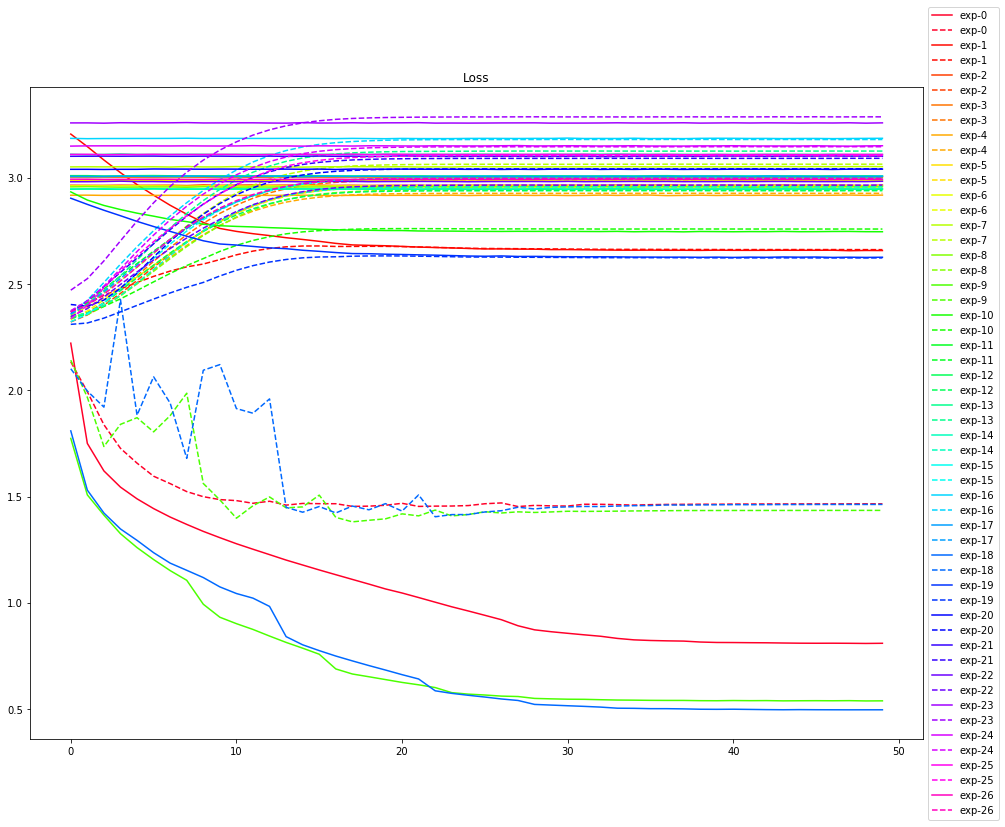

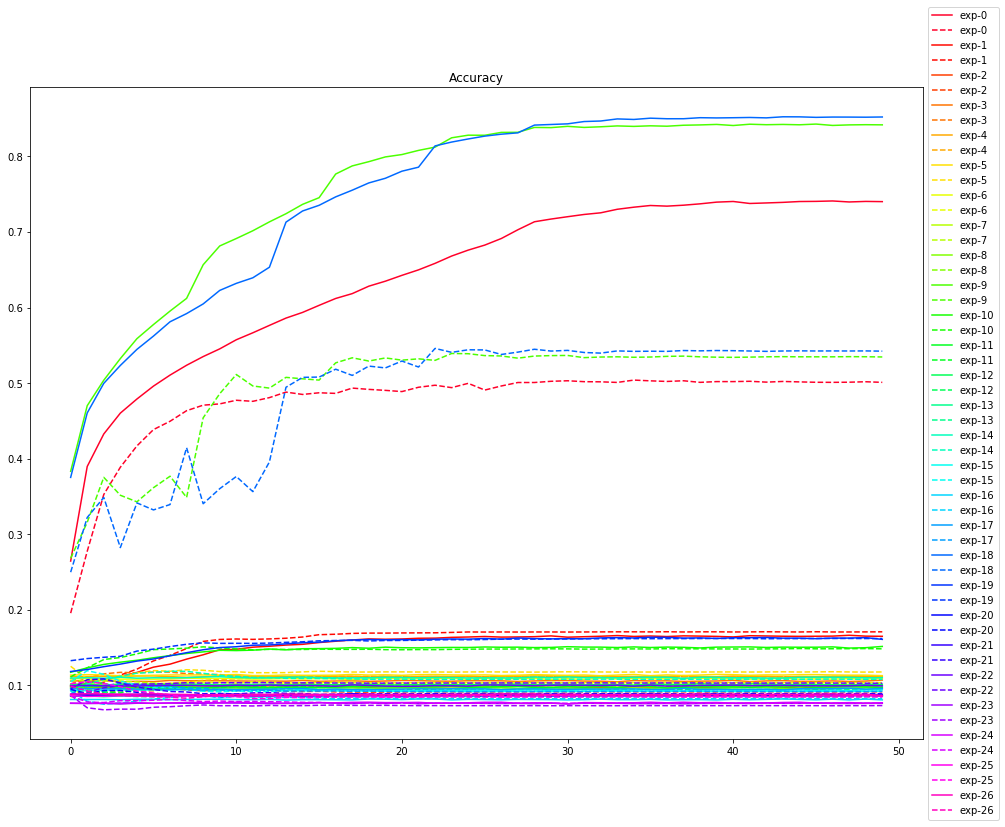

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()